In [1]:
import sympy as smp

def recursive_simplify_evalf(expr, precision=15):
    # Base case: if the expr has no args, it is an atom (number or symbol)
    if not expr.args:
        return expr.evalf(precision).simplify()

    # Recursively process all arguments
    simplified_args = [recursive_simplify_evalf(arg, precision) for arg in expr.args]
    
    # Reconstruct the expression with simplified arguments
    simplified_expr = expr.func(*simplified_args)

    # Apply simplify and evalf on the resulting expression
    return simplified_expr.evalf(precision).simplify()

In [2]:


x = smp.symbols("x")

expr = 3*x**2*(2*smp.pi*x*(smp.sin(3*x+x/2)/(x**2)) + 1e-6 )
display(expr)

expr = expr.simplify()
display(expr)
print(smp.latex(expr))

expr = smp.nsimplify(expr, tolerance=1e-5).evalf(20)
display(expr)
print(smp.latex(expr))

expr = recursive_simplify_evalf(expr)
display(expr)
print(smp.latex(expr))


3*x**2*(1.0e-6 + 2*pi*sin(7*x/2)/x)

x*(3.0e-6*x + 6.0*pi*sin(7*x/2))

x \left(3.0 \cdot 10^{-6} x + 6.0 \pi \sin{\left(\frac{7 x}{2} \right)}\right)


18.849555921538759431*x*sin(7*x/2)

18.849555921538759431 x \sin{\left(\frac{7 x}{2} \right)}


18.8495559215388*x*sin(3.5*x)

18.8495559215388 x \sin{\left(3.5 x \right)}


In [3]:
import os
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"

import sys
sys.path.append('../algorithms/')

from CSOWP_SR import *
from ExpressionTree import *
import utils

# import pandas as pd
import numpy as np
import pickle
import re
import sympy as smp
# import edist.ted as ted

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import itertools
import edist.ted as ted
import scipy

# Preprocessing and Loading

In [4]:
funcs_dict = {
    "F1_specific": "lambda x: 1.57 + 24.3*x", "F4_specific": "lambda x: -2.3 + 0.13*np.sin(x)", 
    "F5_specific": "lambda x: 3 + 2.13*np.log(x)", "F6_specific": "lambda x: 1.3 + 0.13*np.sqrt(x)",
    "F7_specific": "lambda x: 213.809408*(1-np.exp(-0.547237*x))", 
    "F11_specific": "lambda x: 6.87 + 11*np.cos(7.23*x**3)",
    "F1": "lambda x: 1.57 + 24.3*x", "F4": "lambda x: -2.3 + 0.13*np.sin(x)", 
    "F5": "lambda x: 3 + 2.13*np.log(x)", "F6": "lambda x: 1.3 + 0.13*np.sqrt(x)",
    "F7": "lambda x: 213.809408*(1-np.exp(-0.547237*x))", 
    "F11": "lambda x: 6.87 + 11*np.cos(7.23*x**3)",
    "logistic_specific": "lambda x: 10*np.exp(-0.5*np.exp(-0.5*x + 2))",
    "logistic": "lambda x: 10*np.exp(-0.5*np.exp(-0.5*x + 2))",
    "logistic_noTanh": "lambda x: 10*np.exp(-0.5*np.exp(-0.5*x + 2))",
    "projectile_motion_specific": "lambda x: 6*x -9.8*x**2",
    "projectile_motion": "lambda x: 6*x -9.8*x**2",
    "damped_pendulum_specific": "lambda x: np.exp(-x/10)*(3*np.cos(2*x))",
    "damped_pendulum": "lambda x: np.exp(-x/10)*(3*np.cos(2*x))",
    "radioactive_decay_specific": "lambda x: 10*np.exp(-0.5*x)", 
    "radioactive_decay": "lambda x: 10*np.exp(-0.5*x)"
    }

expected_data = pd.DataFrame(columns=["nodes", "adj", "problem", "expected_string"])
expected_data

symbols = {"x": smp.symbols("x", positive=True, real=True)}

for name, function in funcs_dict.items():
    function = function[10:]
    function = smp.parse_expr(function.replace("np.", ""), local_dict=symbols).simplify()
    tree = utils.exprToTree(function, single_name=True)
    node, adj = tree.parentChildRepr().values()
    df = pd.DataFrame([{"nodes": node, "adj": adj, "problem": name, "expected_string": function,
                          "expected_tree": tree}])
    expected_data = pd.concat([expected_data, df])

expected_data.set_index("problem", drop=True, inplace=True)
# expected_data

In [5]:
with open("datasets/ted_data.pickle", "rb") as file:
    ted_data = pickle.load(file).reset_index(drop=True)

# with open("ted_data_original.pickle", "rb") as file:
#     ted_data_original = pickle.load(file)

def print_full(df, lines=100):
    pd.set_option('display.max_rows', lines)
    display(df.head(lines))
    pd.reset_option('display.max_rows')

In [6]:
expected = {}

for index, row in ted_data.iterrows():
    problem = row.problem
    expected[index] = expected_data.loc[problem].nodes

expected_dict = {"expected_nodes": expected}

expected_df = pd.DataFrame(expected_dict, index=expected.keys())
ted_data = pd.concat([ted_data, expected_df], axis=1)

In [7]:
import pandas as pd

custom_order = ["BFGS", "BFGS_random", "CG", "CG_random", 
                "LS", "random_LS", "PSO_NEW", "Nelder-Mead", "Nelder-Mead_random",
                "NoOpt", "differential_evolution", "dual_annealing"]

# Sort by the custom order without converting to categorical
ted_data = ted_data.sort_values(by="optimization", key=lambda x: x.map({val: i for i, val in enumerate(custom_order)}))
# ted_data.head()

In [8]:
sizes = []

for i, row in ted_data.iterrows():
    tree = utils.exprToTree(row.solution_string)
    size = len(tree)
    sizes.append(size)

ted_data["size"] = sizes

In [9]:
def problem_info(data, metric="MSE"):
    problems = data["problem"].unique()

    dfs = []

    for problem in problems:
        info_dict = {}

        filt_data = data[data["problem"] == problem][metric]
        info_dict["problem"] = problem
        info_dict["metric"] = metric
        info_dict["var"] = filt_data.var()
        info_dict["std"] = filt_data.std()
        info_dict["mean"] = filt_data.mean()

        df = pd.DataFrame([info_dict])
        dfs.append(df)
    return pd.concat(dfs).reset_index(drop=True)

def method_info(data, metric="MSE"):
    opts = data["optimization"].unique()

    dfs = []

    for opt in opts:
        info_dict = {}

        filt_data = data[data["optimization"] == opt][metric]
        info_dict["optimization"] = opt
        info_dict["metric"] = metric
        info_dict["var"] = filt_data.var()
        info_dict["std"] = filt_data.std()
        info_dict["mean"] = filt_data.mean()

        df = pd.DataFrame([info_dict])
        dfs.append(df)
    return pd.concat(dfs).reset_index(drop=True)

def all_info(data, metric="MSE"):
    problems = data["problem"].unique()
    opts = data["optimization"].unique()

    final_dfs=[]

    for problem in problems:
        problem_data = data[data["problem"] == problem]

        dfs = []

        for opt in opts:
            info_dict = {}

            filt_data = problem_data[problem_data["optimization"] == opt][metric]
            info_dict["optimization"] = opt
            info_dict["metric"] = metric
            info_dict["var"] = filt_data.var()
            info_dict["std"] = filt_data.std()
            info_dict["mean"] = filt_data.mean()

            df = pd.DataFrame([info_dict])
            dfs.append(df)

        problem_df = pd.concat(dfs)
        problem_df["problem"] = problem
        final_dfs.append(problem_df)
    
    return pd.concat(final_dfs).sort_values("optimization").reset_index(drop=True)
    

In [10]:
problems = ted_data["problem"].unique()
problems_std = []
problems_specific = []

for problem in problems:
    if "specific" in problem or "noTanh" in problem:
        problems_specific.append(problem)
    else:
        problems_std.append(problem)


removed_problems_std = ["projectile_motion", "damped_pendulum", "radiocative_decay", "F11"]
problems_std = [x for x in problems_std if x not in removed_problems_std]

removed_problems_specific = ["projectile_motion_specific", "damped_pendulum_specific", "radiocative_decay_specific", "logistic_noTanh", "F11_specific"]
problems_specific = [x for x in problems_specific if x not in removed_problems_specific]

problems_std, problems_specific

(['F4', 'F7', 'F6', 'F5', 'F1', 'logistic', 'radioactive_decay'],
 ['radioactive_decay_specific',
  'F5_specific',
  'logistic_specific',
  'F1_specific',
  'F4_specific',
  'F6_specific',
  'F7_specific'])

In [11]:
problems_std = ["F1", "F4", "F5", "F6", "F7", "logistic"]
problems_specific = ["F1_specific", "F4_specific", "F5_specific", "F6_specific", "F7_specific", "logistic_specific"]

In [12]:
problems_std_title = [x.replace("_", " ").title() for x in problems_std]
problems_specific_title = [x.replace("_", " ").title() for x in problems_specific]

In [13]:
sizes = []
for i, row in expected_data.iterrows():
    solution = utils.exprToTree(row.expected_string)
    size = len(solution)
    sizes.append(size)

expected_data["size"] = sizes

sizes = {}

for value, row in zip(expected_data.index, expected_data["size"]):
    sizes[value] = row

In [14]:
ted_data["MSE"] = ted_data["MSE"].apply(lambda x: 1e-12 if x < 1e-12 else x)

In [15]:
X_true_data = {"F1": np.linspace(-5, 5, 1000), "F4": np.linspace(-5, 5, 1000),
               "F5": np.linspace(0.1, 10, 1000), "F6": np.linspace(0.1, 10, 1000),
               "F7": np.linspace(0.1, 10, 1000), "F11": np.linspace(-5, 5, 1000),
               "logistic": np.linspace(-5, 15, 1000), "projectile_motion": np.linspace(-5, 5, 1000),
               "damped_pendulum": np.linspace(-5, 5, 1000), "radioactive_decay": np.linspace(-5, 5, 1000)}

func_true_data = {"F1": lambda x: 1.57 + 24.3*x, "F4": lambda x: -2.3 + 0.13*np.sin(x),
                  "F5": lambda x: 3 + 2.13*np.log(x), "F6": lambda x: 1.3 + 0.13*np.sqrt(x),
                  "F7": lambda x: 213.81*(1-np.exp(-0.547237*x)), "F11": lambda x: 6.87 + 11*np.cos(7.23*x**3),
                  "logistic": lambda x: 10*np.exp(-0.5*np.exp(-0.5*x+2)), "projectile_motion": lambda x: 6*x - 9.8*x**2,
                  "damped_pendulum": lambda x: np.exp(-x/10)*3*np.cos(2*x), "radioactive_decay": lambda x: 10*np.exp(-0.5*x)}

y_true_data = {}
for key, value in X_true_data.items():
    y_true_data[key] = func_true_data[key](value)
    y_true_data[f"{key}_specific"] = func_true_data[key](value)

y_true_data["logistic_noTanh"] = func_true_data["logistic"](X_true_data["logistic"])

var_true_data = {}
for key, value in y_true_data.items():
    var_true_data[key] = np.var(value)

var_true_data

{'F1': np.float64(4930.601351351353),
 'F1_specific': np.float64(4930.601351351353),
 'F4': np.float64(0.008916312956581159),
 'F4_specific': np.float64(0.008916312956581159),
 'F5': np.float64(3.5842191990942673),
 'F5_specific': np.float64(3.5842191990942673),
 'F6': np.float64(0.008890012671387624),
 'F6_specific': np.float64(0.008890012671387624),
 'F7': np.float64(2409.8350802576665),
 'F7_specific': np.float64(2409.8350802576665),
 'F11': np.float64(63.16088798705079),
 'F11_specific': np.float64(63.16088798705079),
 'logistic': np.float64(17.714624444367832),
 'logistic_specific': np.float64(17.714624444367832),
 'projectile_motion': np.float64(5657.525056097317),
 'projectile_motion_specific': np.float64(5657.525056097317),
 'damped_pendulum': np.float64(5.576935853945721),
 'damped_pendulum_specific': np.float64(5.576935853945721),
 'radioactive_decay': np.float64(902.5333397408258),
 'radioactive_decay_specific': np.float64(902.5333397408258),
 'logistic_noTanh': np.float64(1

In [16]:
R2 = []

for index, row in ted_data.iterrows():
    R2_score = 1 - row.MSE/var_true_data[row.problem]
    R2.append(R2_score)

ted_data["R2"] = R2

In [17]:
def TED_MSE_table(optimization, ted_threshold=3, MSE_threshold=1e-6):
    values = optimization[["TED", "MSE"]]

    table = np.zeros((2,2))
    correct = 0

    for index, row in values.iterrows():
        if row.TED <= ted_threshold and row.MSE <= MSE_threshold:
            table[0,0] += 1
        elif row.TED <= ted_threshold and row.MSE >= MSE_threshold:
            table[0,1] += 1
        elif row.TED >= ted_threshold and row.MSE <= MSE_threshold:
            table[1,0] += 1
        elif row.TED >= ted_threshold and row.MSE >= MSE_threshold:
            table[1,1] += 1

        if row.TED == 0:
            correct += 1

    table = pd.DataFrame(table, columns=["Positive", "Negative"], index=["Positive", "Negative"])

    total_TP = table.iloc[0,0] if table.iloc[0,0] > 0 else np.inf

    return table, correct / total_TP

def TED_R2_table(optimization, ted_threshold=3, R2_threshold=1e-6):
    values = optimization[["TED", "R2"]]

    table = np.zeros((2,2))
    correct = 0

    for index, row in values.iterrows():
        if row.TED <= ted_threshold and row.R2 >= R2_threshold:
            table[0,0] += 1
        elif row.TED <= ted_threshold and row.R2 <= R2_threshold:
            table[0,1] += 1
        elif row.TED >= ted_threshold and row.R2 >= R2_threshold:
            table[1,0] += 1
        elif row.TED >= ted_threshold and row.R2 <= R2_threshold:
            table[1,1] += 1

        if row.TED == 0:
            correct += 1

    table = pd.DataFrame(table, columns=["Positive", "Negative"], index=["Positive", "Negative"])

    total_TP = table.iloc[0,0] if table.iloc[0,0] > 0 else np.inf

    return table, correct / total_TP

def make_table_data(data, max_ted=5, R2=False):
    problems = data["problem"].unique()
    opts = data["optimization"].unique()

    dfs = []
    for opt in opts:
        opt_data = data[data["optimization"] == opt]
        problem_dict = {}

        for problem in problems:
            problem_data = opt_data[opt_data["problem"] == problem]
            total = len(problem_data)

            TP = []
            FP = []
            FN = []
            TN = []

            thresh_dfs = []
        
            for thresh in range(max_ted+1):
                if R2:
                    table, _ = TED_R2_table(problem_data, ted_threshold=thresh, R2_threshold=0.99)    
                else:
                    table, _ = TED_MSE_table(problem_data, ted_threshold=thresh, MSE_threshold=1e-6)

                TP = table.iloc[0,0]
                FP = table.iloc[0,1]
                FN = table.iloc[1,0]
                TN = table.iloc[1,1]

                problem_dict["threshold"] = thresh
                problem_dict["TP"] = np.array(TP)/total
                problem_dict["FP"] = np.array(FP)/total
                problem_dict["FN"] = np.array(FN)/total
                problem_dict["TN"] = np.array(TN)/total

                thresh_df = pd.DataFrame([problem_dict])
                thresh_dfs.append(thresh_df)


            problem_df = pd.concat(thresh_dfs)
            problem_df["problem"] = problem
            problem_df["optimization"] = opt
        

            dfs.append(problem_df)

        
    table_df = pd.concat(dfs).sort_values("problem").reset_index(drop=True)

    custom_order = ["BFGS", "BFGS_random", "CG", "CG_random", 
                    "LS", "random_LS", "PSO_NEW", "Nelder-Mead", "Nelder-Mead_random",
                    "NoOpt", "differential_evolution", "dual_annealing"]

    # Sort by the custom order without converting to categorical
    table_df = table_df.sort_values(by="optimization", key=lambda x: x.map({val: i for i, val in enumerate(custom_order)}))
    table_df.head()

    return table_df

table_data = make_table_data(ted_data, max_ted=20)
table_data

table_data_R2 = make_table_data(ted_data, max_ted=20, R2=True)

In [18]:
table_data["optimization"].unique()

array(['BFGS', 'BFGS_random', 'CG', 'CG_random', 'LS', 'random_LS',
       'PSO_NEW', 'Nelder-Mead', 'Nelder-Mead_random', 'NoOpt',
       'differential_evolution', 'dual_annealing'], dtype=object)

In [19]:
solution_strings = {}

for i, row in expected_data.iterrows():
    # key = i.replace("_", " ").title()
    solution_strings[i] = smp.latex(row.expected_string)

solution_strings

{'F1_specific': '24.3 x + 1.57',
 'F4_specific': '0.13 \\sin{\\left(x \\right)} - 2.3',
 'F5_specific': '2.13 \\log{\\left(x \\right)} + 3',
 'F6_specific': '0.13 \\sqrt{x} + 1.3',
 'F7_specific': '213.809408 - 213.809408 e^{- 0.547237 x}',
 'F11_specific': '11.0 \\cos{\\left(7.23 x^{3} \\right)} + 6.87',
 'F1': '24.3 x + 1.57',
 'F4': '0.13 \\sin{\\left(x \\right)} - 2.3',
 'F5': '2.13 \\log{\\left(x \\right)} + 3',
 'F6': '0.13 \\sqrt{x} + 1.3',
 'F7': '213.809408 - 213.809408 e^{- 0.547237 x}',
 'F11': '11.0 \\cos{\\left(7.23 x^{3} \\right)} + 6.87',
 'logistic_specific': '10 e^{- 0.5 e^{2 - 0.5 x}}',
 'logistic': '10 e^{- 0.5 e^{2 - 0.5 x}}',
 'logistic_noTanh': '10 e^{- 0.5 e^{2 - 0.5 x}}',
 'projectile_motion_specific': 'x \\left(6 - 9.8 x\\right)',
 'projectile_motion': 'x \\left(6 - 9.8 x\\right)',
 'damped_pendulum_specific': '3 e^{- \\frac{x}{10}} \\cos{\\left(2 x \\right)}',
 'damped_pendulum': '3 e^{- \\frac{x}{10}} \\cos{\\left(2 x \\right)}',
 'radioactive_decay_specific'

In [20]:
solution_strings["F7"] = r"213.809408\left(1 - e^{- 0.547237 x}\right)"
solution_strings["F7_specific"] = r"213.809408\left(1 - e^{- 0.547237 x}\right)"

In [21]:
def custom_title(text):
    # Use regex to find words that are not all caps and apply title casing only to them
    return re.sub(r'\b([a-z]+)\b', lambda match: match.group(1).title(), text)

opt_names = {}
for key in ted_data["optimization"].unique():
    opt_names[key] = custom_title(key.replace("_", " "))
opt_names["PSO_NEW"] = "PSO"
opt_names["random_LS"] = "LS Random"
opt_names

{'BFGS': 'BFGS',
 'BFGS_random': 'BFGS Random',
 'CG': 'CG',
 'CG_random': 'CG Random',
 'LS': 'LS',
 'random_LS': 'LS Random',
 'PSO_NEW': 'PSO',
 'Nelder-Mead': 'Nelder-Mead',
 'Nelder-Mead_random': 'Nelder-Mead Random',
 'NoOpt': 'NoOpt',
 'differential_evolution': 'Differential Evolution',
 'dual_annealing': 'Dual Annealing'}

In [22]:
problem_names = {}
for key in ted_data["problem"].unique():
    problem_names[key] = custom_title(key.replace("_", " "))

problem_names

{'radioactive_decay_specific': 'Radioactive Decay Specific',
 'F4': 'F4',
 'F7': 'F7',
 'F6': 'F6',
 'F5': 'F5',
 'F1': 'F1',
 'F5_specific': 'F5 Specific',
 'logistic_specific': 'Logistic Specific',
 'F11': 'F11',
 'logistic': 'Logistic',
 'projectile_motion_specific': 'Projectile Motion Specific',
 'logistic_noTanh': 'Logistic noTanh',
 'projectile_motion': 'Projectile Motion',
 'damped_pendulum': 'Damped Pendulum',
 'damped_pendulum_specific': 'Damped Pendulum Specific',
 'radioactive_decay': 'Radioactive Decay',
 'F1_specific': 'F1 Specific',
 'F4_specific': 'F4 Specific',
 'F6_specific': 'F6 Specific',
 'F7_specific': 'F7 Specific',
 'F11_specific': 'F11 Specific'}

In [23]:
# filt = ted_data[ted_data["optimization"] == "NoOpt"]
# filt[filt["R2"] >= 0.99].head(60)

# Plot Settings

In [24]:
sns.set_theme("paper")

plt.rcParams.update({
    "font.size": 12,
    "text.usetex": True,
    "axes.titlesize": 14, 
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.labelsize": 12
})


default_figsize = (12, 16)
default_plots = (6, 2)


color_map = sns.color_palette("icefire", 7)

In [25]:
icefire_palette = sns.color_palette("icefire_r", 14)[0:6] + sns.color_palette("icefire_r", 14)[8:]
rocket_palette = sns.color_palette("rocket", 15)[3:]

rocket_palette_d = [sns.color_palette("rocket", 14)[1]] + sns.color_palette("rocket", 14)[3:]

In [26]:
sns.color_palette("rocket", 14)

[(0.10132312, 0.06286782, 0.16604287),
 (0.19804623, 0.09465217, 0.23478512),
 (0.29977678, 0.11356089, 0.29254823),
 (0.40642019, 0.12151801, 0.33288464),
 (0.51728314, 0.1179558, 0.35453252),
 (0.63139686, 0.10067417, 0.35664819),
 (0.74297501, 0.08747196, 0.33329799),
 (0.83850183, 0.14025098, 0.2876878),
 (0.90848638, 0.24568473, 0.24598324),
 (0.94291042, 0.37549479, 0.26369821),
 (0.95681685, 0.49882008, 0.34555431),
 (0.96298491, 0.6126247, 0.45145074),
 (0.96544032, 0.72010124, 0.57640375),
 (0.97071849, 0.82151775, 0.71987163)]

# Figures

## Problems table

In [27]:
expressions_dict = {
    "F1": r"1.57 + 24.3x",
    "F4": r"-2.3 + 0.13\sin(x)",
    "F5": r"3 + 2.13\ln(x)",
    "F6": r"1.3 + 0.13\sqrt(x)",
    "F7": r"213.809408(1-e^{-0.547237x})",
    "F11": r"6.87 + 11\cos(7.23x^3)",
    "logistic": r"10e^{-0.5e^{-0.5 + 2}}",
    "projectile_motion": r"6x - 9.8x^2",
    "damped_pendulum": r"e^{-x/10}(3\cos(2x))",
    "radioactive_decay": r"10e^{-0.5x}"
}

expressions_dict

{'F1': '1.57 + 24.3x',
 'F4': '-2.3 + 0.13\\sin(x)',
 'F5': '3 + 2.13\\ln(x)',
 'F6': '1.3 + 0.13\\sqrt(x)',
 'F7': '213.809408(1-e^{-0.547237x})',
 'F11': '6.87 + 11\\cos(7.23x^3)',
 'logistic': '10e^{-0.5e^{-0.5 + 2}}',
 'projectile_motion': '6x - 9.8x^2',
 'damped_pendulum': 'e^{-x/10}(3\\cos(2x))',
 'radioactive_decay': '10e^{-0.5x}'}

In [28]:
to_table_dict = {}

for key, value in funcs_dict.items():
    if "specific" not in key and "noTanh" not in key:
        to_table_dict[problem_names[key]] = f"${expressions_dict[key]}$"

to_table_dict

{'F1': '$1.57 + 24.3x$',
 'F4': '$-2.3 + 0.13\\sin(x)$',
 'F5': '$3 + 2.13\\ln(x)$',
 'F6': '$1.3 + 0.13\\sqrt(x)$',
 'F7': '$213.809408(1-e^{-0.547237x})$',
 'F11': '$6.87 + 11\\cos(7.23x^3)$',
 'Logistic': '$10e^{-0.5e^{-0.5 + 2}}$',
 'Projectile Motion': '$6x - 9.8x^2$',
 'Damped Pendulum': '$e^{-x/10}(3\\cos(2x))$',
 'Radioactive Decay': '$10e^{-0.5x}$'}

In [29]:
problems_table = pd.DataFrame({
    "Reference Name": to_table_dict.keys(),
    "Expression": to_table_dict.values(),
    "Interval": [
        [-5, 5], [-5, 5], [0.1, 10], [0.1, 10], 
        [0.1, 10], [-5, 5], [-5, 15], [-5, 5], 
        [-5, 5], [-5, 5]
    ]
})

print(problems_table.to_latex())

\begin{tabular}{llll}
\toprule
 & Reference Name & Expression & Interval \\
\midrule
0 & F1 & $1.57 + 24.3x$ & [-5, 5] \\
1 & F4 & $-2.3 + 0.13\sin(x)$ & [-5, 5] \\
2 & F5 & $3 + 2.13\ln(x)$ & [0.1, 10] \\
3 & F6 & $1.3 + 0.13\sqrt(x)$ & [0.1, 10] \\
4 & F7 & $213.809408(1-e^{-0.547237x})$ & [0.1, 10] \\
5 & F11 & $6.87 + 11\cos(7.23x^3)$ & [-5, 5] \\
6 & Logistic & $10e^{-0.5e^{-0.5 + 2}}$ & [-5, 15] \\
7 & Projectile Motion & $6x - 9.8x^2$ & [-5, 5] \\
8 & Damped Pendulum & $e^{-x/10}(3\cos(2x))$ & [-5, 5] \\
9 & Radioactive Decay & $10e^{-0.5x}$ & [-5, 5] \\
\bottomrule
\end{tabular}



## MSE Boxplot

In [30]:
MSE_difficulty = {
    "F1": "(E)",
    "F1_specific": "(E)",
    "F4": "(M)",
    "F4_specific": "(E)",
    "F5": "(M)",
    "F5_specific": "(E)",
    "F6": "(M)",
    "F6_specific": "(M)",
    "logistic": "(H)",
    "logistic_specific": "(H)",
    "F7": "(H)",
    "F7_specific": "(H)"
}

C:\Users\guilherme\AppData\Local\Temp\ipykernel_8548\3630269910.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_yticklabels(y_labels)
C:\Users\guilherme\AppData\Local\Temp\ipykernel_8548\3630269910.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i+1].set_yticklabels(y_labels)
C:\Users\guilherme\AppData\Local\Temp\ipykernel_8548\3630269910.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_yticklabels(y_labels)
C:\Users\guilherme\AppData\Local\Temp\ipykernel_8548\3630269910.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i+1].set_yticklabels(y_labels)
C:\Users\guilherme\AppData\Local\Temp\ipykernel_8548\3630269

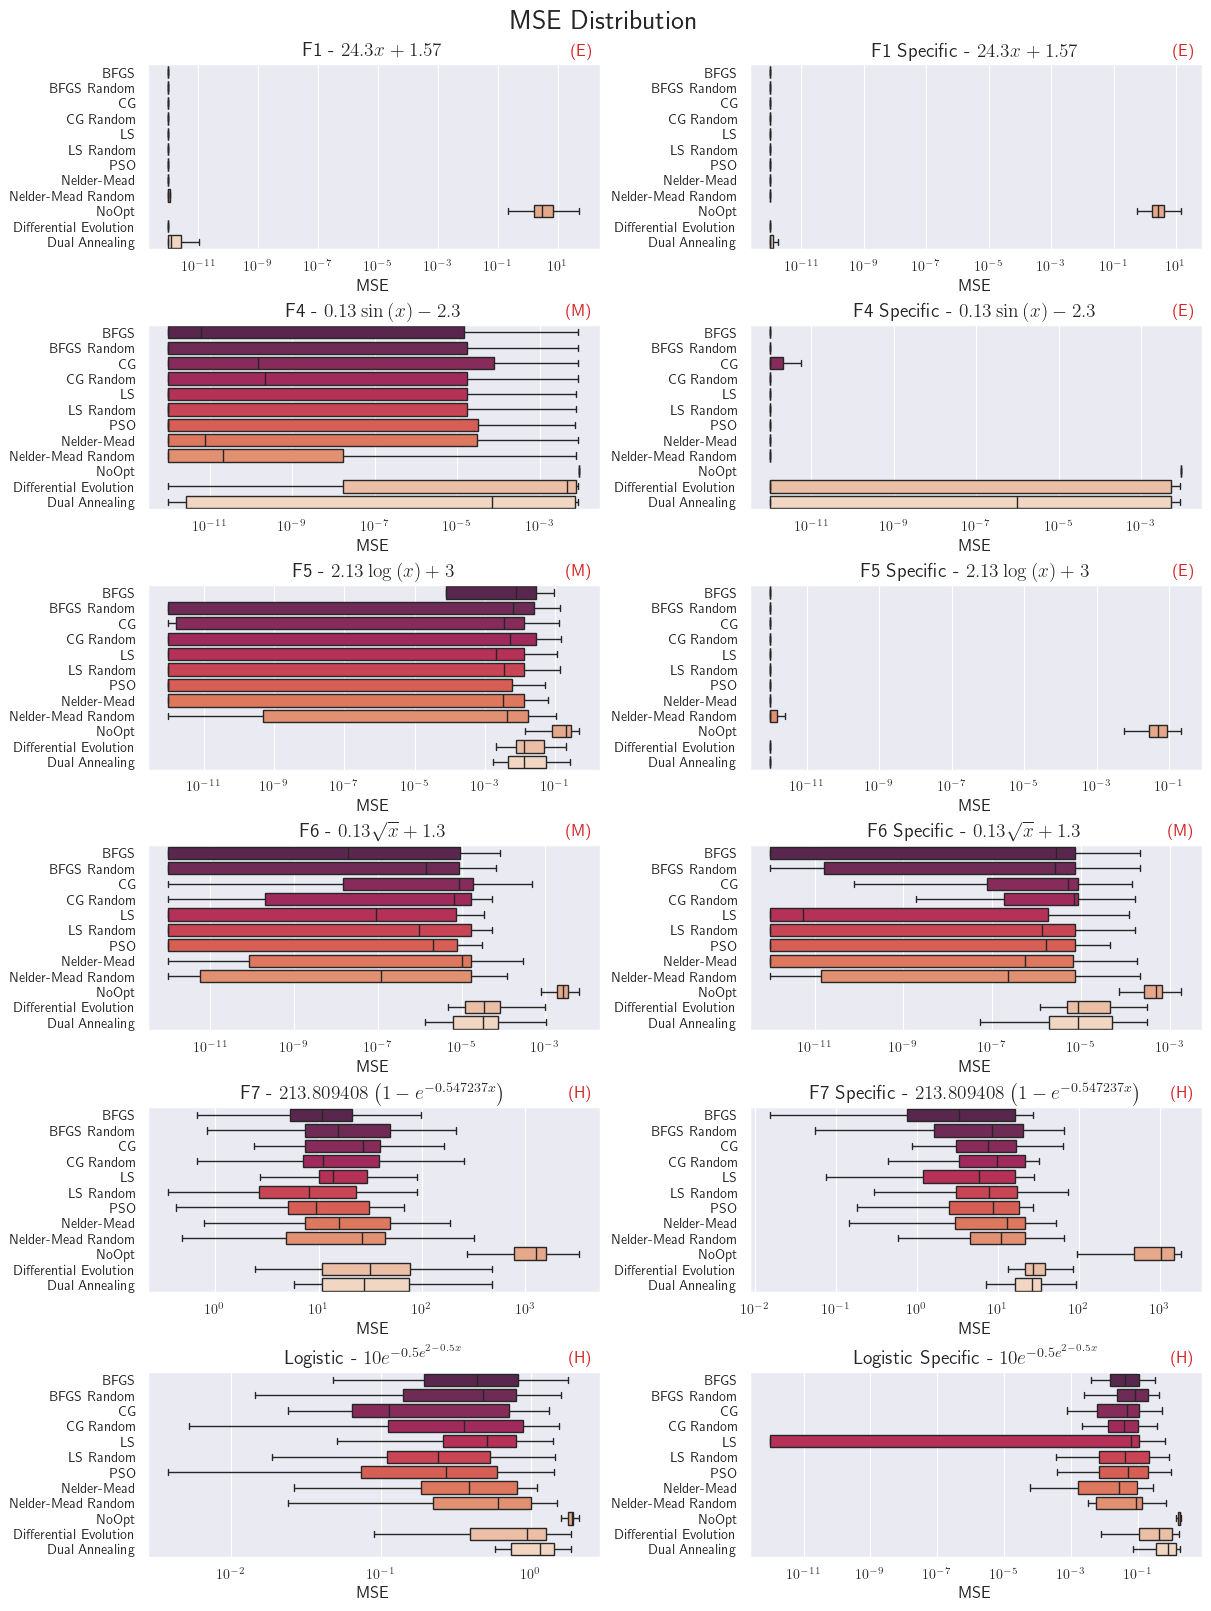

In [31]:
# Standard
fig, axs = plt.subplots(*default_plots, constrained_layout=True, figsize=default_figsize)

axs = axs.flatten()

clip_boundaries={
    "F7_specific": (1e-14, 1e4),
    "F11": (50, 1e4),
    "F11_specific": (10, 1e4),
    "damped_pendulum": (2e-3, 1e4),
    "damped_pendulum_specific": (1e-3, 1e4)
}

for c in range(int(len(axs)/2)):
    i = c*2
    data = ted_data[ted_data["problem"] == problems_std[c]].copy()

    # if problems_std[c] in clip_boundaries.keys():
    #     print(problems_std[c])
    #     data["MSE"].clip(*clip_boundaries[problems_std[c]], inplace=True)

    # axs[i].set_title(problems_std[c])
    axs[i].set_title(f"{problems_std_title[c]} - " + fr"${solution_strings[problems_std[c]]}$")
    axs[i].set_xscale("log")
    
    sns.boxplot(data, x="MSE", y="optimization", hue="optimization", ax=axs[i], 
                palette=rocket_palette, showfliers=False)
    
    y_labels = [opt_names[label.get_text()] for label in axs[i].get_yticklabels()]
    axs[i].set_yticklabels(y_labels)
    axs[i].set_ylabel("")

    axs[i].text(0.985, 1.12, f"{MSE_difficulty[problems_std[c]]}", 
           ha='right', va='top', transform=axs[i].transAxes, c="tab:red",
           fontweight="bold")
    
    
    for d, problem in enumerate(problems_specific):
        if f"{problems_std[c]}_" in problem:
            break
        
    data = ted_data[ted_data["problem"] == problem].copy()

    # if problems_specific[d] in clip_boundaries.keys():
    #     print(problems_specific[d])
    #     data["MSE"].clip(*clip_boundaries[problems_specific[d]], inplace=True)

    # axs[i+1].set_title(problems_specific[d])
    axs[i+1].set_title(f"{problems_specific_title[d]} - " + fr"${solution_strings[problems_specific[d]]}$")
    axs[i+1].set_xscale("log")
    

    sns.boxplot(data, x="MSE", y="optimization", hue="optimization", ax=axs[i+1],
                palette=rocket_palette, showfliers=False)
    
    y_labels = [opt_names[label.get_text()] for label in axs[i+1].get_yticklabels()]
    axs[i+1].set_yticklabels(y_labels)
    axs[i+1].set_ylabel("")

    axs[i+1].text(0.985, 1.12, f"{MSE_difficulty[problems_specific[d]]}", 
           ha='right', va='top', transform=axs[i+1].transAxes, c="tab:red",
           fontweight="bold")
    
# print(axs[i].get_yticklabels())
plt.suptitle("MSE Distribution", fontsize=20)
plt.savefig("figures/MSE_boxplot.jpg", dpi=300)

In [ ]:
# Standard
fig, axs = plt.subplots(*default_plots, constrained_layout=True, figsize=default_figsize)

axs = axs.flatten()

clip_boundaries={
    "F7_specific": (1e-14, 1e4),
    "F11": (50, 1e4),
    "F11_specific": (10, 1e4),
    "damped_pendulum": (2e-3, 1e4),
    "damped_pendulum_specific": (1e-3, 1e4)
}

for c in range(int(len(axs)/2)):
    i = c*2
    data = ted_data[ted_data["problem"] == problems_std[c]].copy()

    # if problems_std[c] in clip_boundaries.keys():
    #     print(problems_std[c])
    #     data["MSE"].clip(*clip_boundaries[problems_std[c]], inplace=True)

    # axs[i].set_title(problems_std[c])
    axs[i].set_title(f"{problems_std_title[c]} - " + fr"${solution_strings[problems_std[c]]}$")
    # axs[i].set_xscale("log")
    
    sns.boxplot(data, x="R2", y="optimization", hue="optimization", ax=axs[i], 
                palette=rocket_palette, showfliers=False)
    
    y_labels = [opt_names[label.get_text()] for label in axs[i].get_yticklabels()]
    axs[i].set_yticklabels(y_labels)
    axs[i].set_ylabel("")

    axs[i].text(0.985, 1.12, f"{MSE_difficulty[problems_std[c]]}", 
           ha='right', va='top', transform=axs[i].transAxes, c="tab:red",
           fontweight="bold")
    
    
    for d, problem in enumerate(problems_specific):
        if f"{problems_std[c]}_" in problem:
            break
        
    data = ted_data[ted_data["problem"] == problem].copy()

    # if problems_specific[d] in clip_boundaries.keys():
    #     print(problems_specific[d])
    #     data["MSE"].clip(*clip_boundaries[problems_specific[d]], inplace=True)

    # axs[i+1].set_title(problems_specific[d])
    axs[i+1].set_title(f"{problems_specific_title[d]} - " + fr"${solution_strings[problems_specific[d]]}$")
    # axs[i+1].set_xscale("log")
    

    sns.boxplot(data, x="R2", y="optimization", hue="optimization", ax=axs[i+1],
                palette=rocket_palette, showfliers=False)
    
    y_labels = [opt_names[label.get_text()] for label in axs[i+1].get_yticklabels()]
    axs[i+1].set_yticklabels(y_labels)
    axs[i+1].set_ylabel("")

    axs[i+1].text(0.985, 1.12, f"{MSE_difficulty[problems_specific[d]]}", 
           ha='right', va='top', transform=axs[i+1].transAxes, c="tab:red",
           fontweight="bold")
    
# print(axs[i].get_yticklabels())
plt.suptitle("R2 Distribution", fontsize=20)
plt.savefig("figures/R2_boxplot.jpg", dpi=300)

## TED Boxplot

In [33]:
TED_difficulty = {
    "F1": "(E)",
    "F1_specific": "(E)",
    "F4": "(M)",
    "F4_specific": "(E)",
    "F5": "(M)",
    "F5_specific": "(E)",
    "F6": "(M)",
    "F6_specific": "(M)",
    "logistic": "(H)",
    "logistic_specific": "(H)",
    "F7": "(H)",
    "F7_specific": "(H)"
}

C:\Users\guilherme\AppData\Local\Temp\ipykernel_8548\3982862691.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_yticklabels(y_labels)
C:\Users\guilherme\AppData\Local\Temp\ipykernel_8548\3982862691.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i+1].set_yticklabels(y_labels)
C:\Users\guilherme\AppData\Local\Temp\ipykernel_8548\3982862691.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_yticklabels(y_labels)
C:\Users\guilherme\AppData\Local\Temp\ipykernel_8548\3982862691.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i+1].set_yticklabels(y_labels)
C:\Users\guilherme\AppData\Local\Temp\ipykernel_8548\3982862

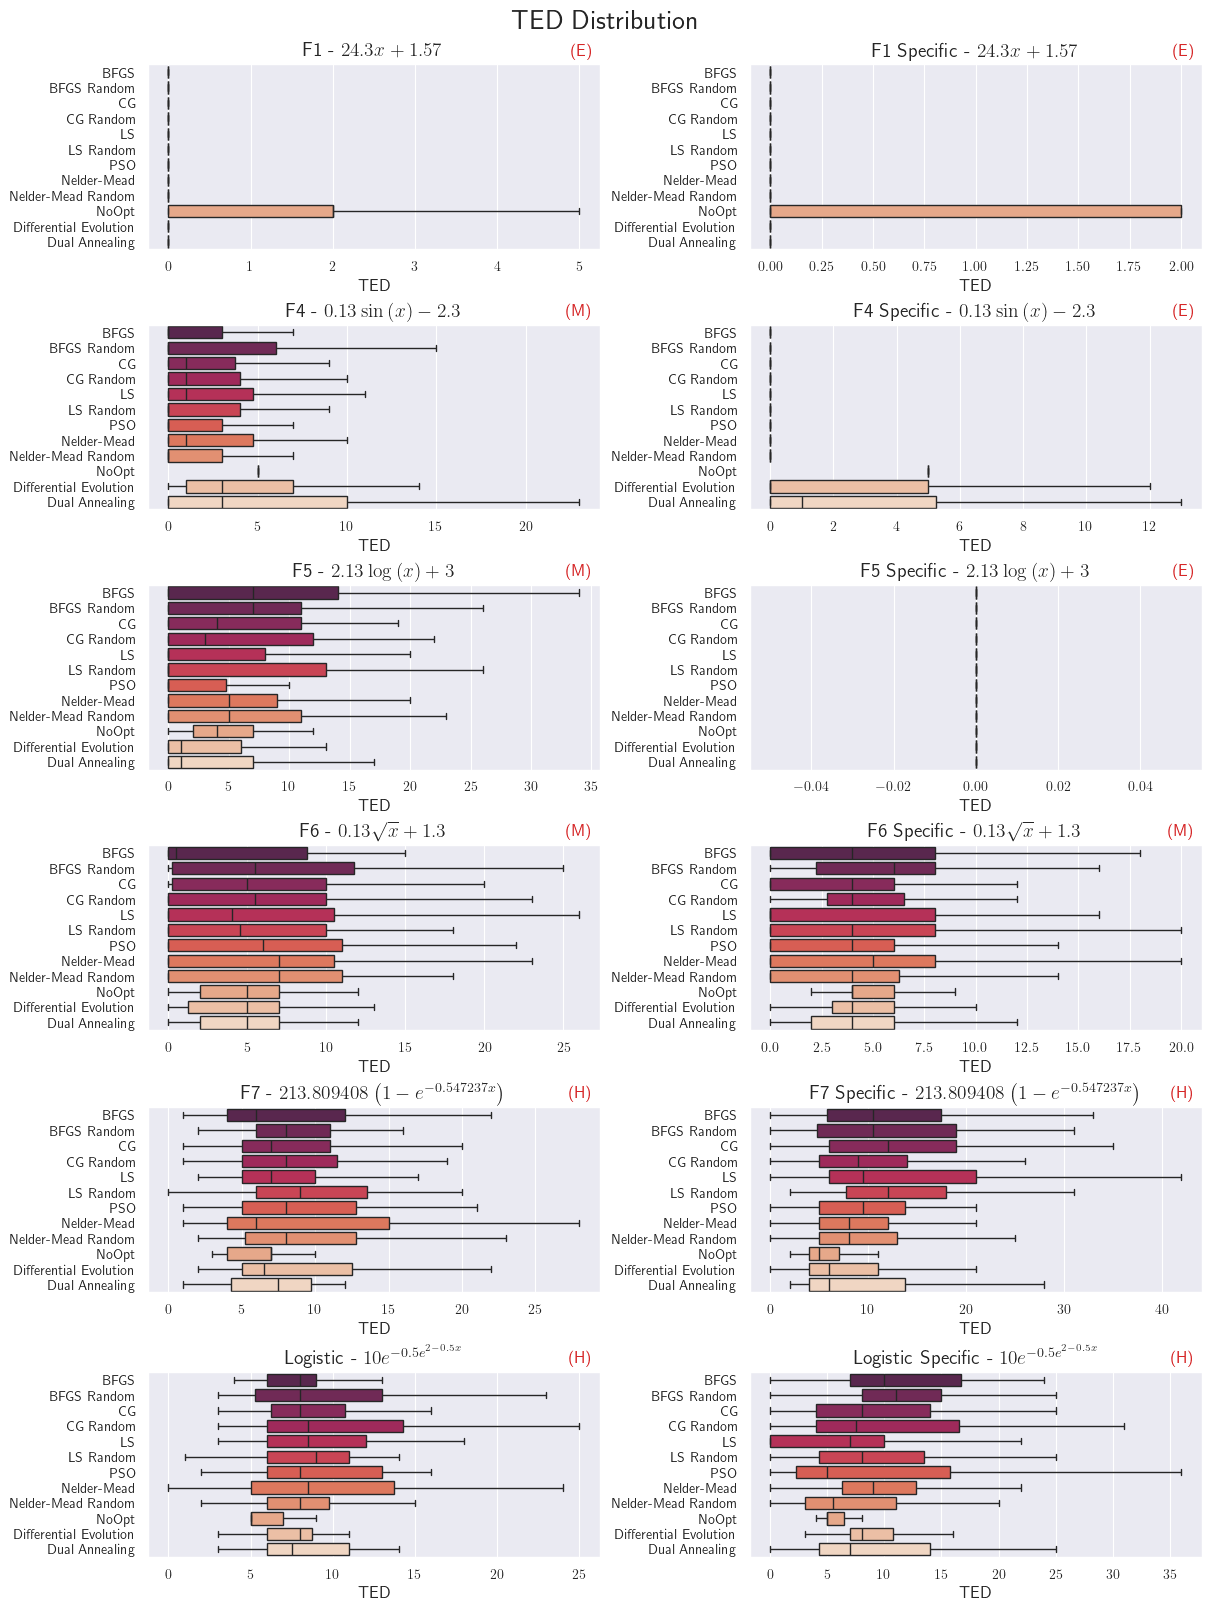

In [34]:
# Standard
fig, axs = plt.subplots(*default_plots, constrained_layout=True, figsize=default_figsize)

axs = axs.flatten()

for c in range(int(len(axs)/2)):
    i = c*2
    data = ted_data[ted_data["problem"] == problems_std[c]]
    # axs[i].set_title(problems_std[c])
    axs[i].set_title(f"{problems_std_title[c]} - " + fr"${solution_strings[problems_std[c]]}$")
    
    sns.boxplot(data, x="TED", y="optimization", hue="optimization", ax=axs[i], 
                palette=rocket_palette, showfliers=False)
    
    y_labels = [opt_names[label.get_text()] for label in axs[i].get_yticklabels()]
    axs[i].set_yticklabels(y_labels)
    axs[i].set_ylabel("")

    axs[i].text(0.985, 1.12, f"{TED_difficulty[problems_std[c]]}", 
           ha='right', va='top', transform=axs[i].transAxes, c="tab:red",
           fontweight="bold")

    # current_xticks = axs[i].get_xticks()
    # if 10 not in current_xticks:
    #     axs[i].set_xticks(np.append(current_xticks, 10))
    
    
    for d, problem in enumerate(problems_specific):
        if f"{problems_std[c]}_" in problem:
            break
        
    data = ted_data[ted_data["problem"] == problem]
    # axs[i+1].set_title(problems_specific[d])
    axs[i+1].set_title(f"{problems_specific_title[d]} - " + fr"${solution_strings[problems_specific[d]]}$")


    sns.boxplot(data, x="TED", y="optimization", hue="optimization", ax=axs[i+1], 
                palette=rocket_palette, showfliers=False)
    
    y_labels = [opt_names[label.get_text()] for label in axs[i+1].get_yticklabels()]
    axs[i+1].set_yticklabels(y_labels)
    axs[i+1].set_ylabel("")

    axs[i+1].text(0.985, 1.12, f"{TED_difficulty[problems_specific[d]]}", 
           ha='right', va='top', transform=axs[i+1].transAxes, c="tab:red",
           fontweight="bold")
    
    # current_xticks = axs[i+1].get_xticks()
    # if 10 not in current_xticks:
    #     current_xticks = current_xticks[1:]
    #     axs[i+1].set_xticks(np.append(current_xticks, 10))

plt.suptitle("TED Distribution", fontsize=20)
plt.savefig("figures/TED_boxplot.jpg", dpi=300)

## Correlation Table

### Generally

In [35]:
TED_corr = scipy.stats.pearsonr(ted_data["size"], ted_data["TED"])
MSE_corr = scipy.stats.pearsonr(ted_data["size"], ted_data["MSE"])

corr_df = pd.DataFrame({"Correlation": [TED_corr[0], MSE_corr[0]], "p-value": [TED_corr[1], MSE_corr[1]]}, index=["TED", "MSE"])
display(corr_df)
print(corr_df.to_latex())

,Correlation,p-value
TED,0.953407,0.000000
MSE,0.002074,0.813831


\begin{tabular}{lrr}
\toprule
 & Correlation & p-value \\
\midrule
TED & 0.953407 & 0.000000 \\
MSE & 0.002074 & 0.813831 \\
\bottomrule
\end{tabular}



### Individual

In [36]:
def corr_table(data):
    TED_corr = scipy.stats.pearsonr(data["size"], data["TED"])
    MSE_corr = scipy.stats.pearsonr(data["size"], data["MSE"])

    corr_df = pd.DataFrame({"Correlation": [TED_corr[0], MSE_corr[0]], "p-value": [TED_corr[1], MSE_corr[1]]}, index=["TED", "MSE"])
    
    return corr_df


all_tables = []
for opt in ted_data["optimization"].unique():
    filt_data = ted_data[ted_data["optimization"] == opt]
    table = corr_table(filt_data)
    table.index = pd.MultiIndex.from_product([[opt], table.index], names=["Optimization Type", "Metric"])
    all_tables.append(table)

opt_table_df = pd.concat(all_tables)
opt_table_df.loc["NoOpt"].loc["TED"]["p-value"] = 4.694818e-17
opt_table_df

Correlation        p-value
Optimization Type      Metric                            
BFGS                   TED        0.983360   0.000000e+00
                       MSE        0.200651   6.289722e-12
BFGS_random            TED        0.973517   0.000000e+00
                       MSE        0.221330   8.986692e-14
CG                     TED        0.976185   0.000000e+00
                       MSE        0.228423   1.184701e-14
CG_random              TED        0.976402   0.000000e+00
                       MSE        0.259838   7.582106e-19
LS                     TED        0.971604   0.000000e+00
                       MSE        0.213580   9.877104e-13
random_LS              TED        0.975661   0.000000e+00
                       MSE        0.224548   3.032745e-14
PSO_NEW                TED        0.973935   0.000000e+00
                       MSE        0.264495   2.322059e-15
Nelder-Mead            TED        0.963512   0.000000e+00
                       MSE        0.211446   6.744450e-13
Nelder-Mead_random     TED        0.949568   0.000000e+00
                       MSE        0.240906   2.565164e-16
NoOpt                  TED        0.740579  4.694818e-176
                       MSE       -0.025481   4.187834e-01
differential_evolution TED        0.964275   0.000000e+00
                       MSE        0.195700   1.416652e-10
dual_annealing         TED        0.954533   0.000000e+00
                       MSE        0.142356   6.344421e-06

In [37]:
[rocket_palette_d[0],rocket_palette_d[4]]

[(0.19804623, 0.09465217, 0.23478512), (0.74297501, 0.08747196, 0.33329799)]

C:\Users\guilherme\AppData\Local\Temp\ipykernel_8548\3763134500.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(x_labels)


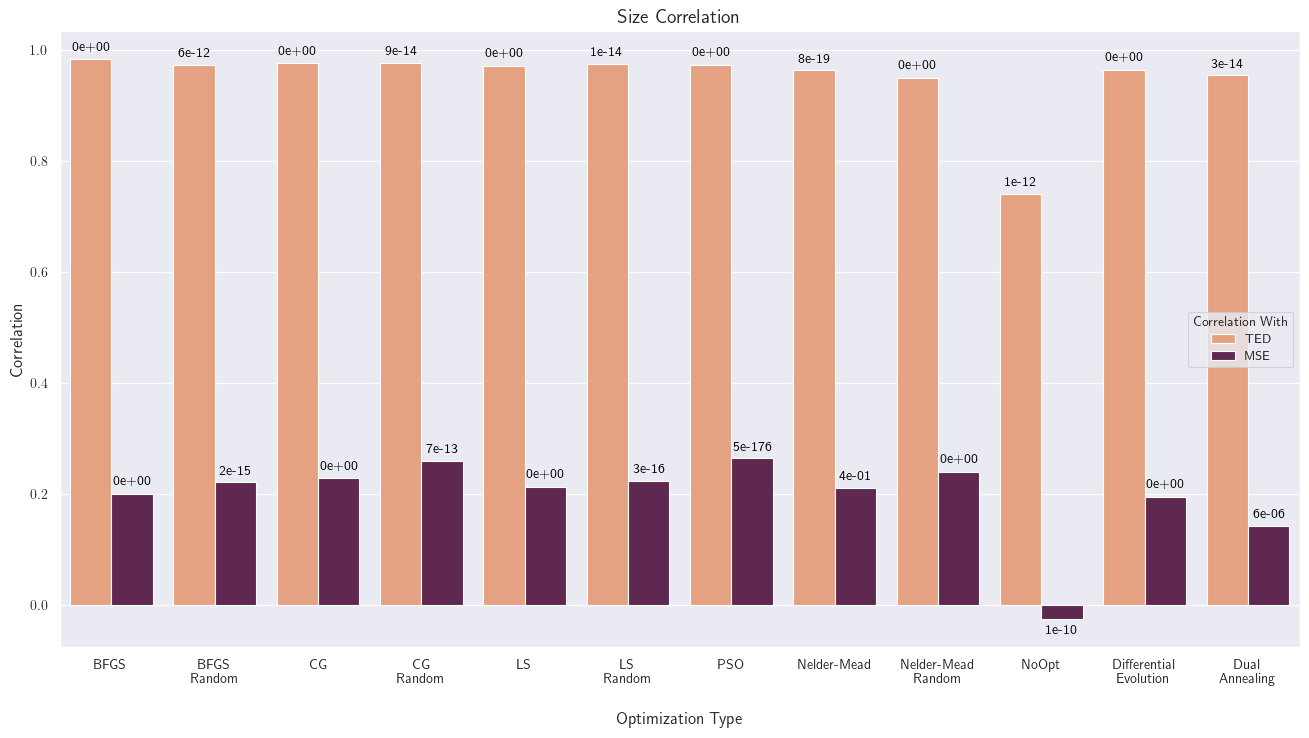

In [38]:
def break_labels(label):
    return label.replace(" ", "\n")

plt.figure(figsize=(16, 8))

opt_table_df_reset = opt_table_df.reset_index()

sns.barplot(x="Optimization Type", y="Correlation", hue="Metric", data=opt_table_df_reset, palette=rocket_palette_d[9:0:-8])
plt.title("Size Correlation")
x_labels = [break_labels(opt_names[label.get_text()]) for label in plt.gca().get_xticklabels()]
plt.gca().set_xticklabels(x_labels)
plt.gca().xaxis.labelpad = 20
plt.legend(title="Correlation With")

# Adding the "p-value" information above each bar
for i, bar in enumerate(plt.gca().patches):
    # Get the height of each bar to position the text
    if i > 23:
        break;

    height = bar.get_height()
    
    # Extract "p-value" from the DataFrame for each bar
    p_value = opt_table_df_reset["p-value"].iloc[i]
    
    # Place the text at the top center of each bar
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x position (center of bar)
        height + 0.01 if height > 0 else height - 0.03,                      # y position (just above the bar)
        f'{p_value:.0e}',                   # Format p-value in scientific notation
        ha='center',                        # Center-align text horizontally
        va='bottom',                        # Align text to bottom so it sits above the bar
        color='black',                      # Set text color
        fontsize=10                         # Set font size
    )

plt.savefig("figures/size_correlation", dpi=300)
plt.show()

C:\Users\guilherme\AppData\Local\Temp\ipykernel_8548\1369008660.py:2: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  TED_corr = scipy.stats.pearsonr(data["MSE"], data["TED"])
C:\Users\guilherme\AppData\Local\Temp\ipykernel_8548\1369008660.py:2: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  TED_corr = scipy.stats.pearsonr(data["MSE"], data["TED"])
C:\Users\guilherme\AppData\Local\Temp\ipykernel_8548\1369008660.py:2: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  TED_corr = scipy.stats.pearsonr(data["MSE"], data["TED"])
C:\Users\guilherme\AppData\Local\Temp\ipykernel_8548\1369008660.py:2: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  TED_corr = scipy.stats.pearsonr(data["MSE"], data["TED"])
C:\Users\guilherme\AppData\Local\Temp\ipykernel_8548\1369008660.py:2: ConstantInputWarning: An input arr

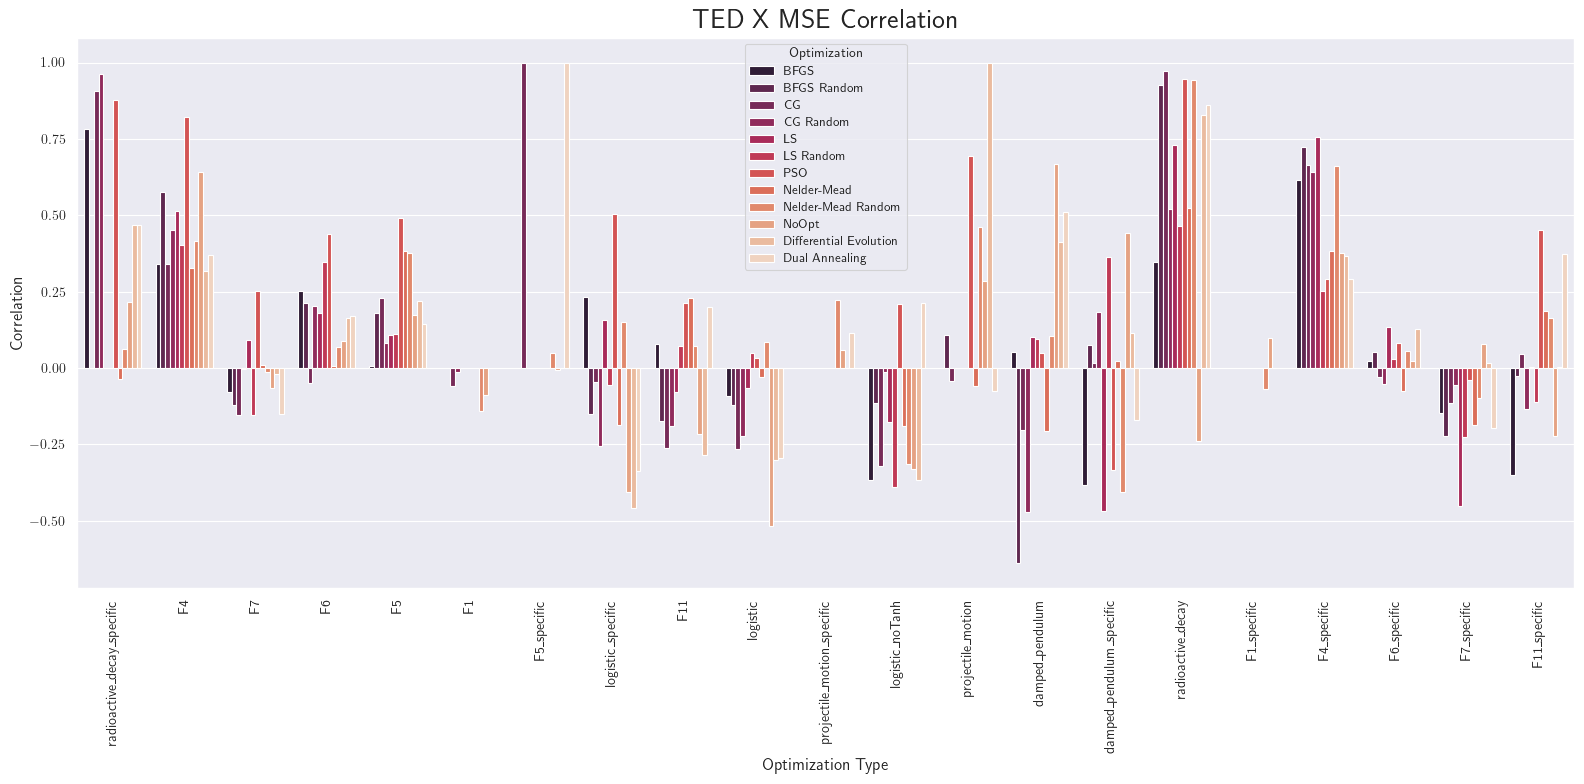

In [39]:
def corr_table(data):
    TED_corr = scipy.stats.pearsonr(data["MSE"], data["TED"])

    corr_df = pd.DataFrame({"Correlation": [TED_corr[0]], "p-value": [TED_corr[1]]}, index=["Corr"])
    
    return corr_df

outer_all = []
for opt in ted_data["optimization"].unique():
    opt_data = ted_data[ted_data["optimization"] == opt]

    all_tables = []
    for problem in opt_data["problem"].unique():
        filt_data = opt_data[opt_data["problem"] == problem]
        table = corr_table(filt_data)
        table.index = pd.MultiIndex.from_product([[problem], table.index], names=["Optimization Type", "Metric"])
        all_tables.append(table)

    opt_table_df = pd.concat(all_tables).reset_index()
    opt_table_df["optimization"] = opt
    # display(opt_table_df)

    outer_all.append(opt_table_df)

outer_table = pd.concat(outer_all).reset_index()

opt_titles = []
for row in outer_table.optimization:
    opt_titles.append(opt_names[row])

outer_table["opt_title"] = opt_titles

# display(outer_table)


plt.figure(figsize=(16, 8))

sns.barplot(x="Optimization Type", y="Correlation", hue="opt_title", data=outer_table, palette=rocket_palette_d)
plt.title("TED X MSE Correlation", fontsize=20)
plt.xticks(rotation=90)
plt.legend(title="Optimization", loc="upper center")
plt.tight_layout()
plt.savefig("figures/TED_MSE_Correlation", dpi=300)
plt.show()

## Sizes Boxplot

In [40]:
size_problems_std = ["F7"]
size_problems_specific = ["F7_specific"]

C:\Users\guilherme\AppData\Local\Temp\ipykernel_8548\3423896218.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_yticklabels(y_labels)
C:\Users\guilherme\AppData\Local\Temp\ipykernel_8548\3423896218.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i+1].set_yticklabels(y_labels)
C:\Users\guilherme\AppData\Local\Temp\ipykernel_8548\3423896218.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_yticklabels(y_labels)
C:\Users\guilherme\AppData\Local\Temp\ipykernel_8548\3423896218.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i+1].set_yticklabels(y_labels)
C:\Users\guilherme\AppData\Local\Temp\ipykernel_8548\3423896

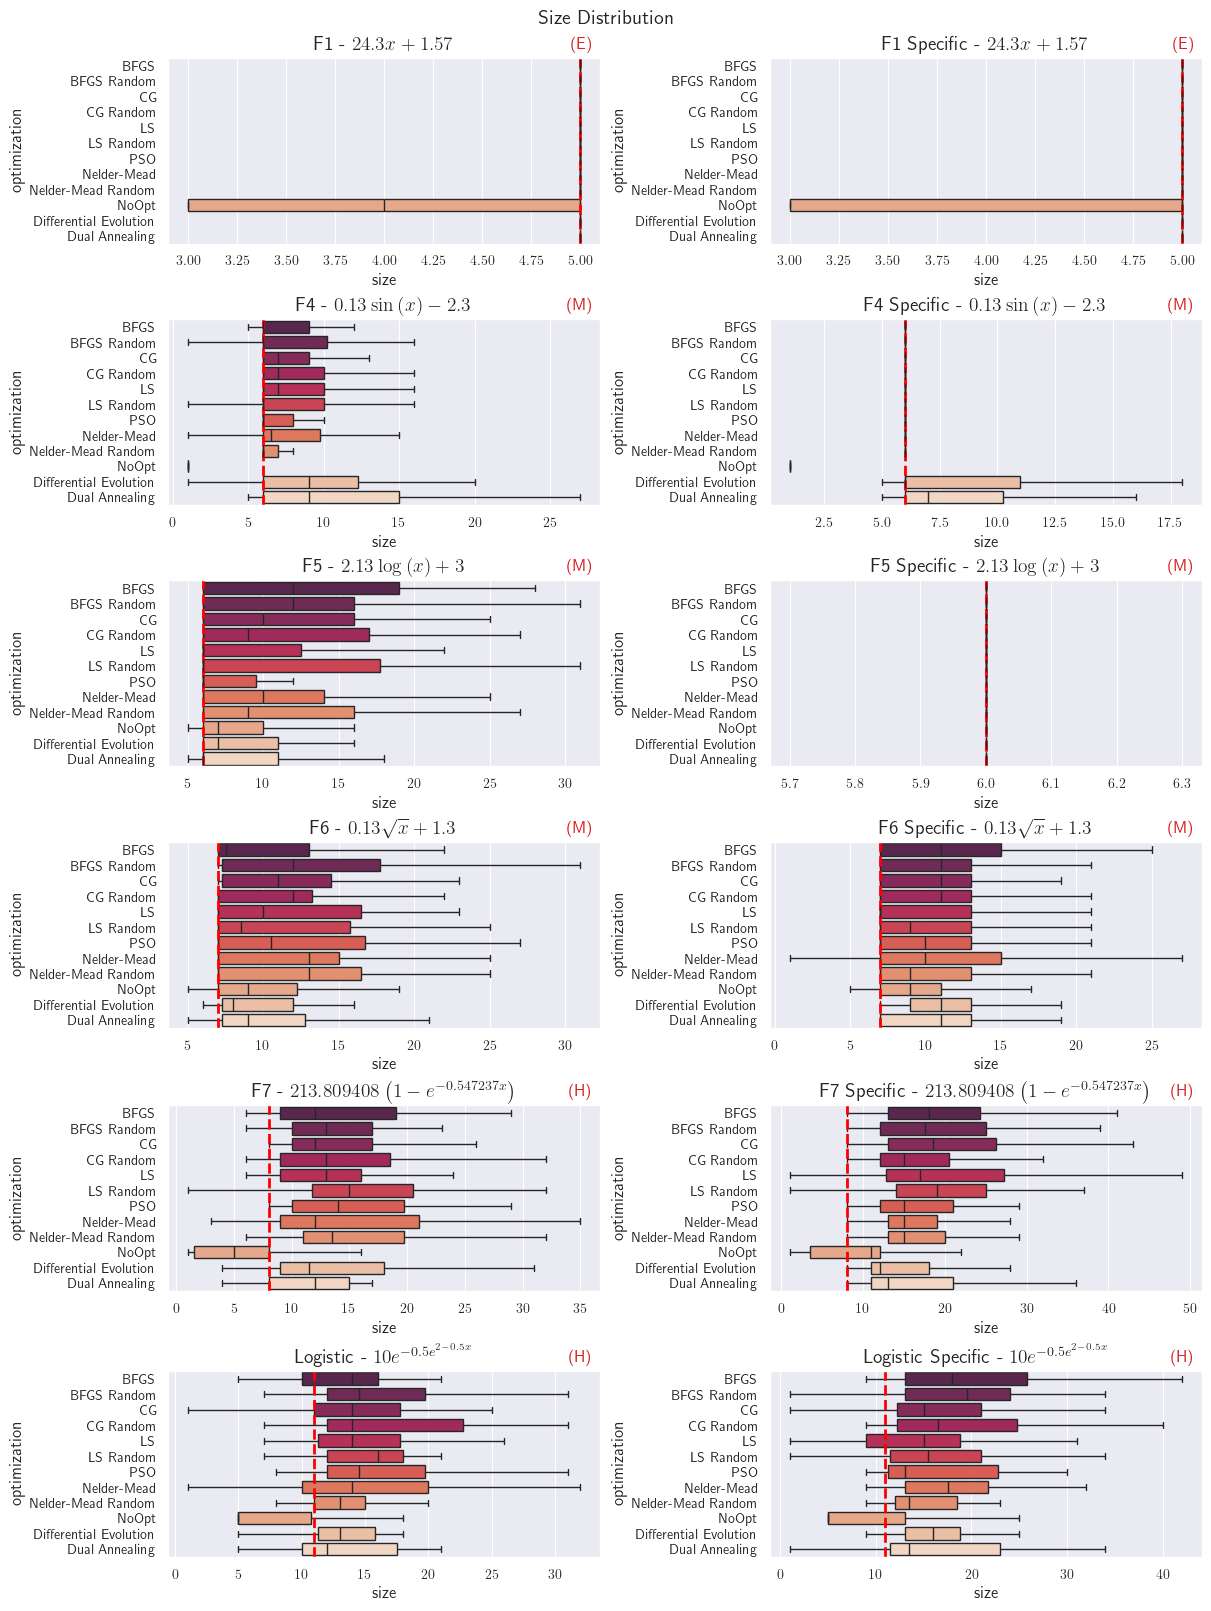

In [41]:
# Standard
fig, axs = plt.subplots(*default_plots, constrained_layout=True, figsize=default_figsize)

axs = axs.flatten()

for c in range(int(len(axs)/2)):
    i = c*2
    data = ted_data[ted_data["problem"] == problems_std[c]]
    # axs[i].set_title(problems_std[c])
    axs[i].set_title(f"{problems_std_title[c]} - " + fr"${solution_strings[problems_std[c]]}$")

    
    sns.boxplot(data, x="size", y="optimization", hue="optimization", ax=axs[i], 
                palette=rocket_palette, showfliers=False)
    
    y_labels = [opt_names[label.get_text()] for label in axs[i].get_yticklabels()]
    axs[i].set_yticklabels(y_labels)

    expected_size = sizes[problems_std[c]]
    axs[i].axvline(x=expected_size, color='red', linestyle='--', linewidth=2)

    current_xticks = axs[i].get_xticks()
    
    axs[i].text(0.985, 1.12, f"{TED_difficulty[problems_std[c]]}", 
           ha='right', va='top', transform=axs[i].transAxes, c="tab:red",
           fontweight="bold")
    
    
    
    for d, problem in enumerate(problems_specific):
        if f"{problems_std[c]}_" in problem:
            break
        
    data = ted_data[ted_data["problem"] == problem]
    # axs[i+1].set_title(problems_specific[d])
    axs[i+1].set_title(f"{problems_specific_title[d]} - " + fr"${solution_strings[problems_specific[d]]}$")

    sns.boxplot(data, x="size", y="optimization", hue="optimization", ax=axs[i+1], 
                palette=rocket_palette, showfliers=False)
    
    y_labels = [opt_names[label.get_text()] for label in axs[i+1].get_yticklabels()]
    axs[i+1].set_yticklabels(y_labels)

    expected_size = sizes[problems_specific[d]]
    axs[i+1].axvline(x=expected_size, color='red', linestyle='--', linewidth=2)
    
    current_xticks = axs[i+1].get_xticks()

    axs[i+1].text(0.985, 1.12, f"{TED_difficulty[problems_std[d]]}", 
           ha='right', va='top', transform=axs[i+1].transAxes, c="tab:red",
           fontweight="bold")
    
    

plt.suptitle("Size Distribution")
plt.savefig("figures/Size_boxplot.jpg", dpi=300)

C:\Users\guilherme\AppData\Local\Temp\ipykernel_8548\3592470554.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_yticklabels(y_labels)
C:\Users\guilherme\AppData\Local\Temp\ipykernel_8548\3592470554.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i+1].set_yticklabels(y_labels)


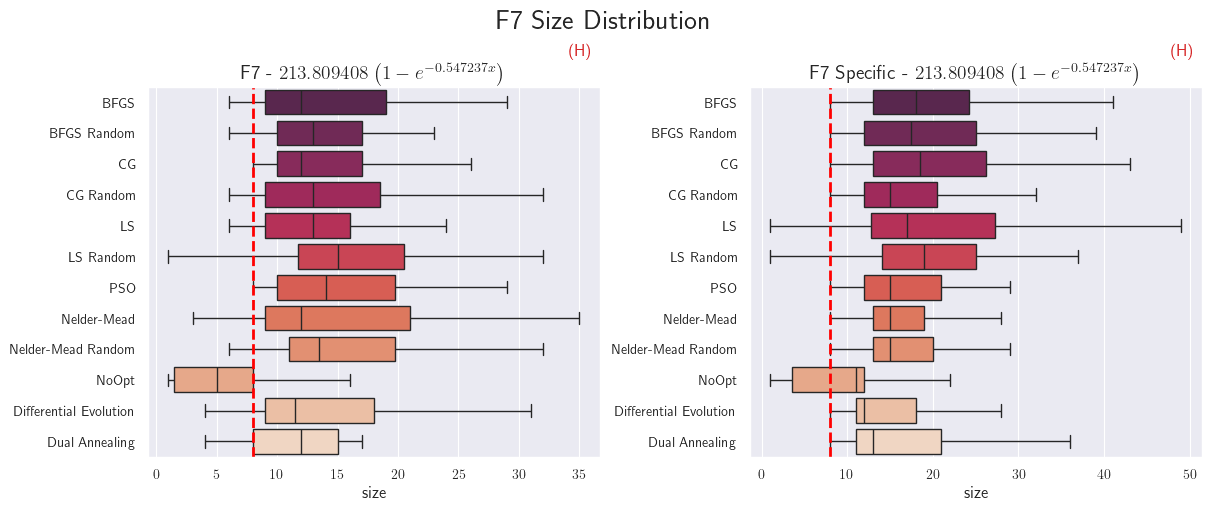

In [42]:
# Standard
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 5))

axs = axs.flatten()

c=0
i = c*2
data = ted_data[ted_data["problem"] == "F7"]
# axs[i].set_title(problems_std[c])
axs[i].set_title(f"F7 - " + fr"${solution_strings["F7"]}$")


sns.boxplot(data, x="size", y="optimization", hue="optimization", ax=axs[i], 
            palette=rocket_palette, showfliers=False)

y_labels = [opt_names[label.get_text()] for label in axs[i].get_yticklabels()]
axs[i].set_yticklabels(y_labels)

expected_size = sizes["F7"]
axs[i].axvline(x=expected_size, color='red', linestyle='--', linewidth=2)

current_xticks = axs[i].get_xticks()

axs[i].text(0.985, 1.12, f"{TED_difficulty["F7"]}", 
    ha='right', va='top', transform=axs[i].transAxes, c="tab:red",
    fontweight="bold")

axs[i].set_ylabel("")


    
data = ted_data[ted_data["problem"] == "F7_specific"]
# axs[i+1].set_title(problems_specific[d])
axs[i+1].set_title(f"F7 Specific - " + fr"${solution_strings["F7_specific"]}$")

sns.boxplot(data, x="size", y="optimization", hue="optimization", ax=axs[i+1], 
            palette=rocket_palette, showfliers=False)

y_labels = [opt_names[label.get_text()] for label in axs[i+1].get_yticklabels()]
axs[i+1].set_yticklabels(y_labels)

expected_size = sizes["F7_specific"]
axs[i+1].axvline(x=expected_size, color='red', linestyle='--', linewidth=2)

current_xticks = axs[i+1].get_xticks()

axs[i+1].text(0.985, 1.12, f"{TED_difficulty["F7_specific"]}", 
    ha='right', va='top', transform=axs[i+1].transAxes, c="tab:red",
    fontweight="bold")
    
axs[i+1].set_ylabel("")
    

plt.suptitle("F7 Size Distribution", fontsize=20)
plt.savefig("figures/Specific_size_boxplot.jpg", dpi=300)

## Problems Scatterplot

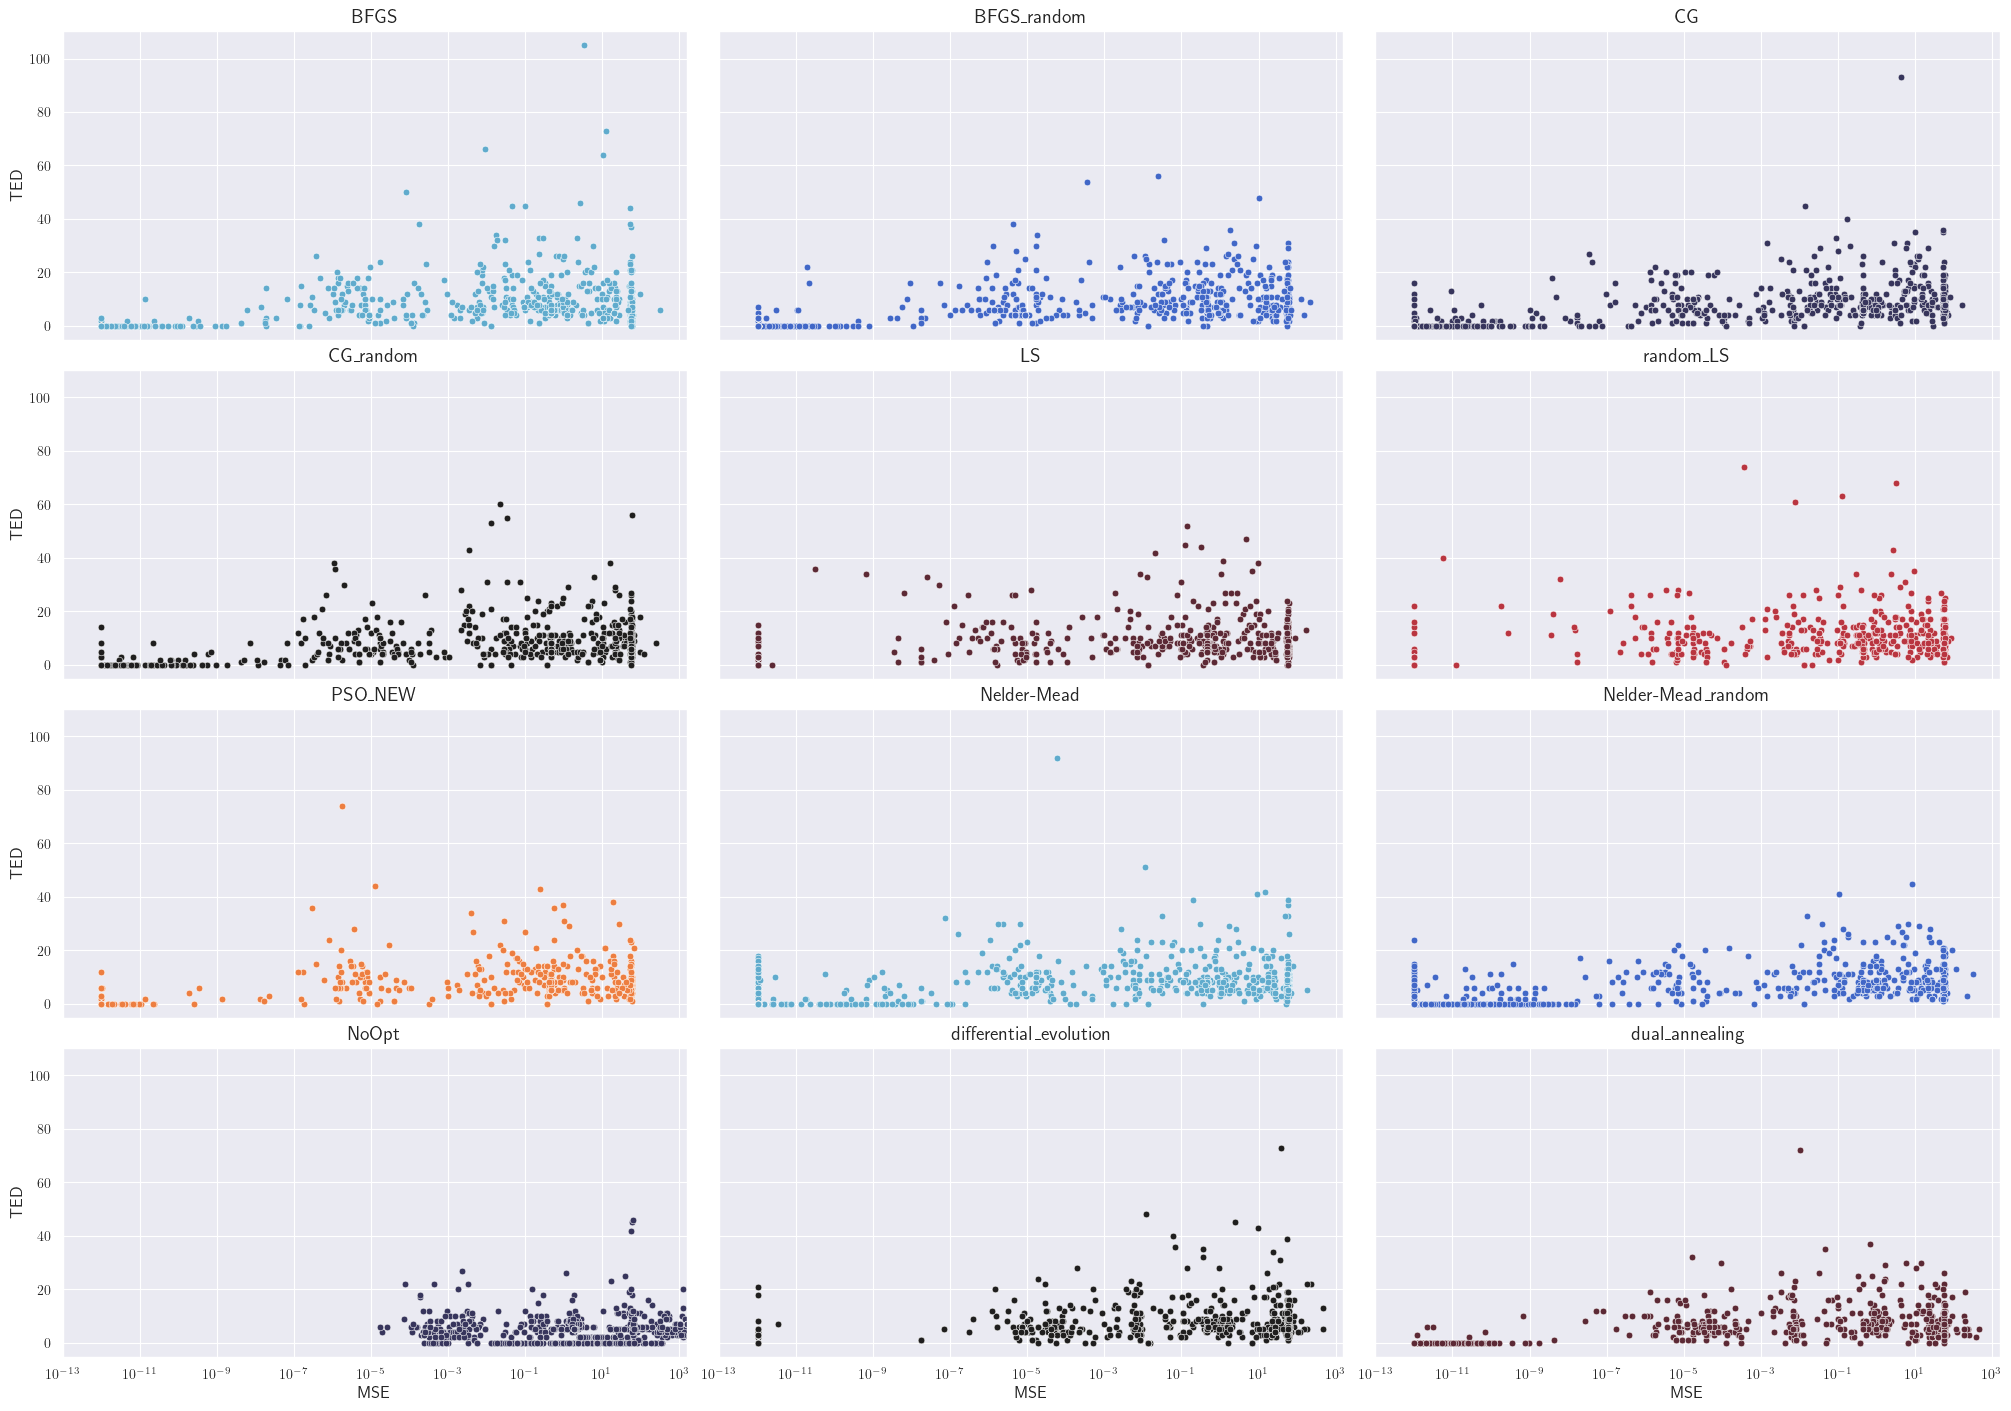

In [43]:
fig, axs = plt.subplots(4, 3, figsize=(20, 14), constrained_layout=True, sharey=True, sharex=True)


opts = list(ted_data["optimization"].unique())
scores = {}
n_true = {}

# opts.remove("PSO")

c=0 

for ax, opt in zip(axs.flatten(), opts):
    filt_data = ted_data[ted_data["optimization"] == opt]

    ax.set_xscale("log")
    sns.scatterplot(data=filt_data, x="MSE", y="TED", color=color_map[c], ax=ax)
    # ax.vlines(1e-4, 0, 35, color="black", linestyle="--")
    
    xmin, xmax = 1e-13, 1591.38

    ax.set_title(opt)
    
    ax.set_xlim(xmin, xmax)
    c = (c+1)%7


# plt.suptitle("'Confusion Matrix' - TED X MSE", fontsize=20)
plt.show()

## Threshold Heatmap

In [44]:
TP_difficulty = {
    "F1": "(E)",
    "F1_specific": "(E)",
    "F4": "(M)",
    "F4_specific": "(E)",
    "F5": "(M)",
    "F5_specific": "(E)",
    "F6": "(M)",
    "F6_specific": "(M)",
    "logistic": "(H)",
    "logistic_specific": "(H)",
    "F7": "(H)",
    "F7_specific": "(H)"
}

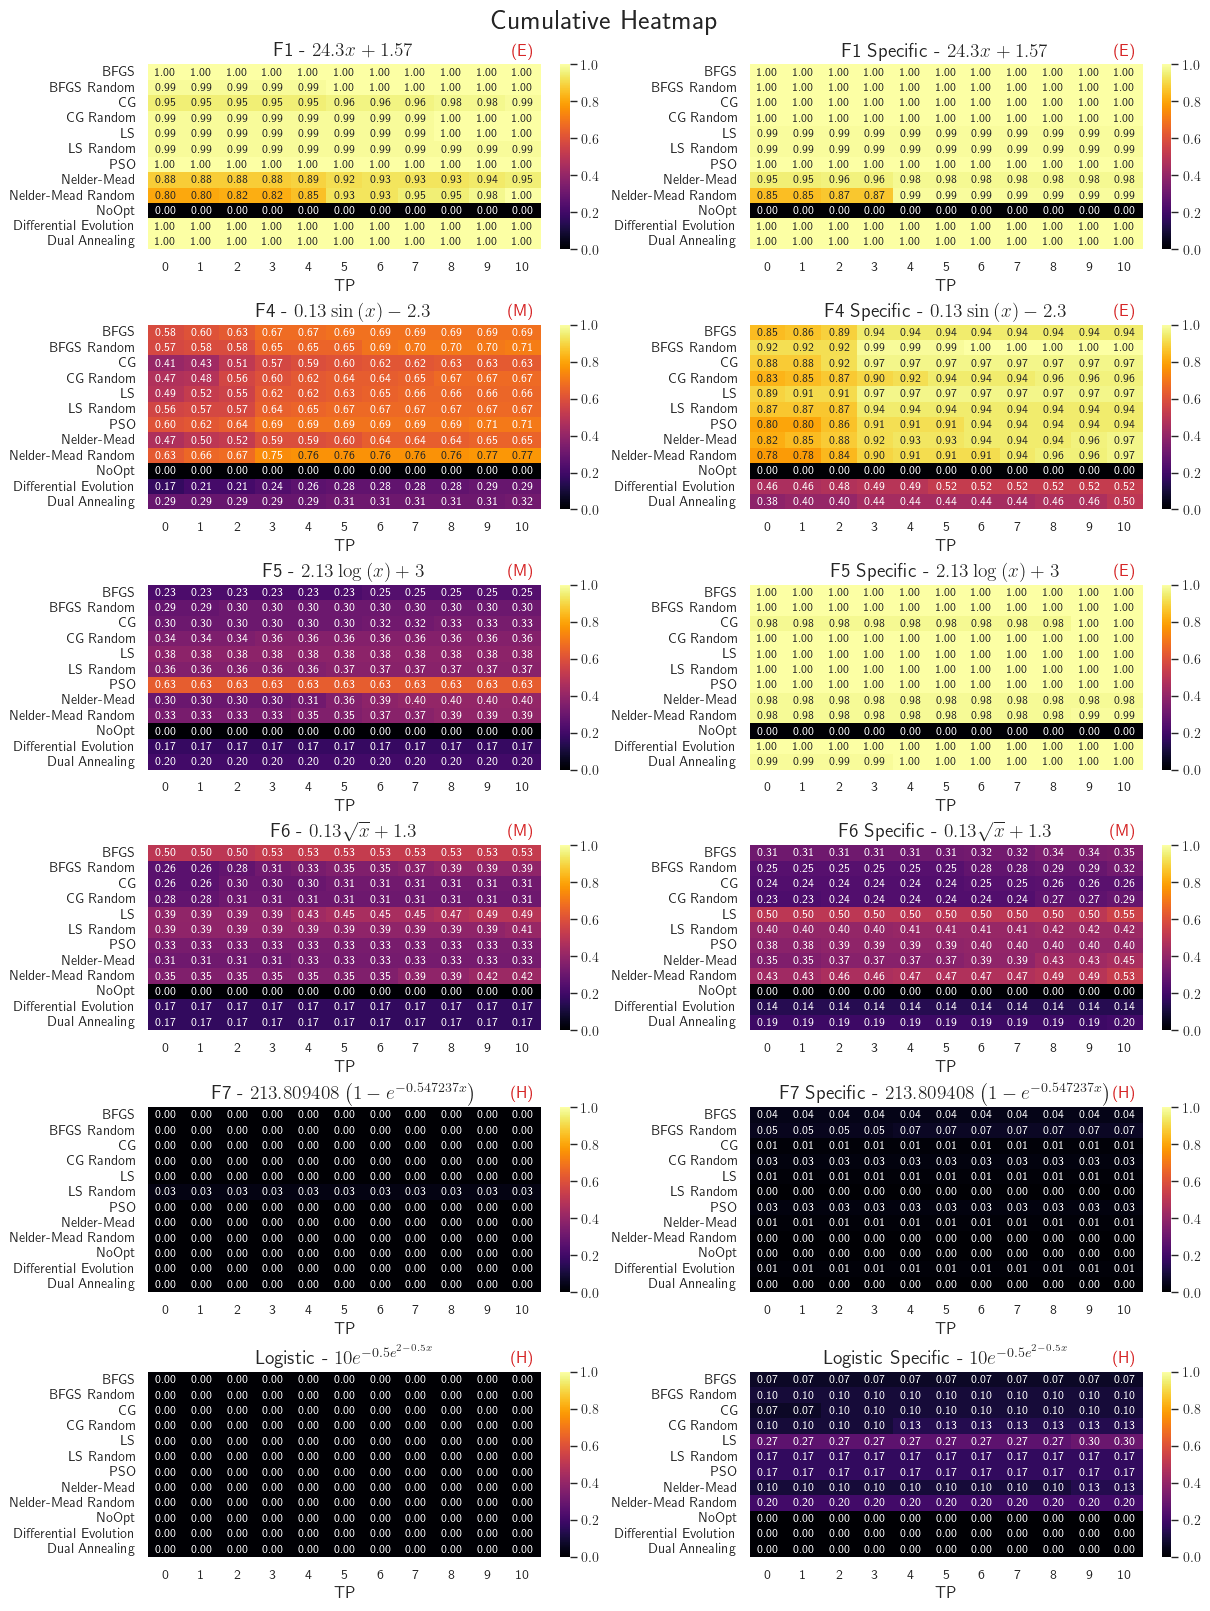

In [ ]:
# Standard
plt.rc('text', usetex=True)  # Enable LaTeX rendering

fig, axs = plt.subplots(*default_plots, constrained_layout=True, figsize=default_figsize)

axs = axs.flatten()

for c in range(int(len(axs)/2)):
    i = c*2

    filtered = table_data[table_data["problem"] == problems_std[c]]
    filtered2 = filtered[filtered["threshold"] <= 10]

    # Pivot the data to create a heatmap matrix
    pivot_data = filtered2.pivot_table(columns="threshold", index="optimization", values="TP")
    pivot_data = pivot_data.sort_index(key=lambda x: x.map({val: i for i, val in enumerate(custom_order)}))

    # Create the heatmap
    sns.heatmap(pivot_data, annot=True, cmap="inferno", ax=axs[i], vmin=0, vmax=1, 
                annot_kws={"size": 8}, fmt=".2f")
    axs[i].set_title(f"{problems_std_title[c]} - " + fr"${solution_strings[problems_std[c]]}$")
    
    axs[i].set_yticks([x+0.5 for x in range(0, 12)])
    y_labels = [opt_names[label] for label in custom_order]
    axs[i].set_yticklabels(y_labels)
    axs[i].set_xlabel("TP")
    axs[i].set_ylabel("")

    axs[i].text(0.985, 1.12, f"{TP_difficulty[problems_std[c]]}", 
           ha='right', va='top', transform=axs[i].transAxes, c="tab:red",
           fontweight="bold")

    for d, problem in enumerate(problems_specific):
        if f"{problems_std[c]}_" in problem:
            break
        
    # axs[i+1].set_title(problems_specific[d])
    axs[i+1].set_title(f"{problems_specific_title[d]} - " + fr"${solution_strings[problems_specific[d]]}$")
    
    filtered = table_data[table_data["problem"] == problems_specific[d]]
    filtered2 = filtered[filtered["threshold"] <= 10]

    # Pivot the data to create a heatmap matrix
    pivot_data = filtered2.pivot_table(columns="threshold", index="optimization", values="TP")
    pivot_data = pivot_data.sort_index(key=lambda x: x.map({val: i for i, val in enumerate(custom_order)}))
    
    # Create the heatmap
    sns.heatmap(pivot_data, annot=True, cmap="inferno", ax=axs[i+1], vmin=0, vmax=1, 
                annot_kws={"size": 8}, fmt=".2f")
    
    axs[i+1].set_yticks([x+0.5 for x in range(0, 12)])
    y_labels = [opt_names[label] for label in custom_order]
    axs[i+1].set_yticklabels(y_labels)
    axs[i+1].set_xlabel("TP")
    axs[i+1].set_ylabel("")

    axs[i+1].text(0.985, 1.12, f"{TP_difficulty[problems_specific[d]]}", 
           ha='right', va='top', transform=axs[i+1  ].transAxes, c="tab:red",
           fontweight="bold")
    

plt.suptitle("Cumulative Heatmap - MSE", fontsize=20)
plt.savefig("figures/Threshold_Heatmap_MSE.jpg", dpi=300)

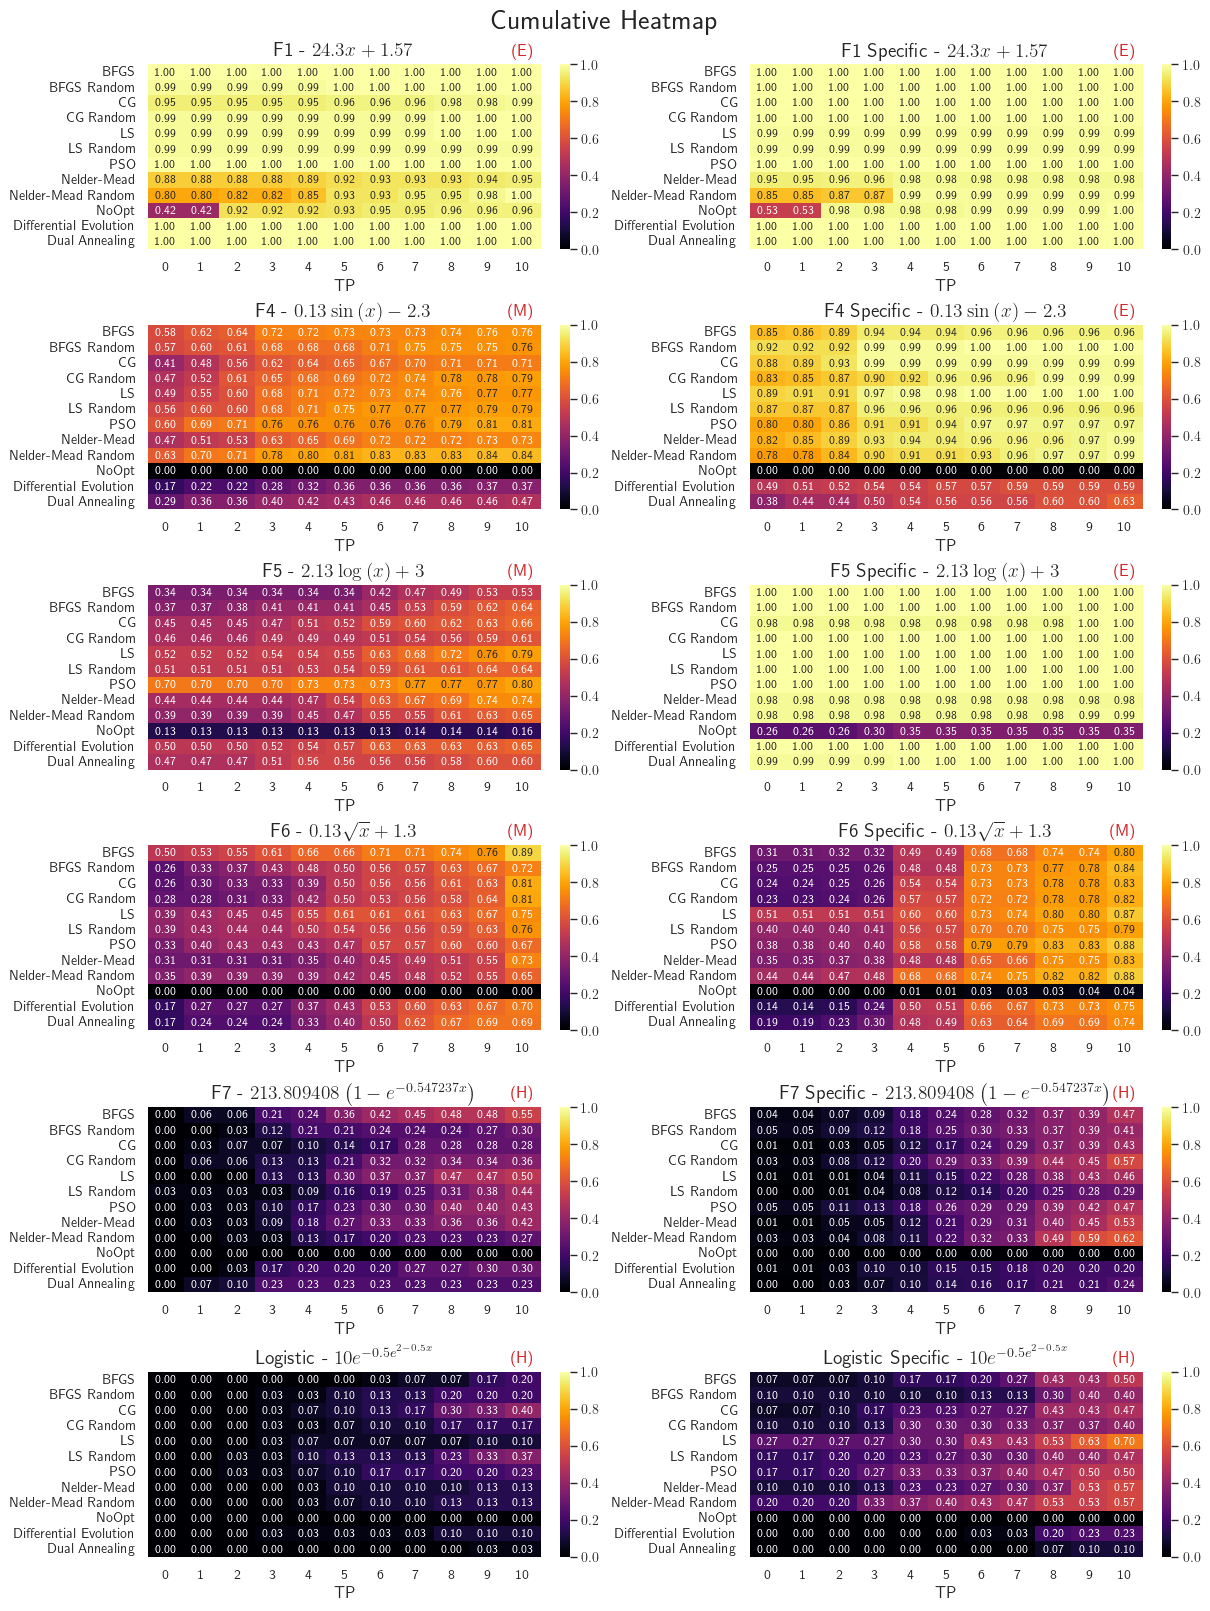

In [46]:
# Standard
plt.rc('text', usetex=True)  # Enable LaTeX rendering

fig, axs = plt.subplots(*default_plots, constrained_layout=True, figsize=default_figsize)

axs = axs.flatten()

for c in range(int(len(axs)/2)):
    i = c*2

    filtered = table_data_R2[table_data_R2["problem"] == problems_std[c]]
    filtered2 = filtered[filtered["threshold"] <= 10]

    # Pivot the data to create a heatmap matrix
    pivot_data = filtered2.pivot_table(columns="threshold", index="optimization", values="TP")
    pivot_data = pivot_data.sort_index(key=lambda x: x.map({val: i for i, val in enumerate(custom_order)}))

    # Create the heatmap
    sns.heatmap(pivot_data, annot=True, cmap="inferno", ax=axs[i], vmin=0, vmax=1, 
                annot_kws={"size": 8}, fmt=".2f")
    axs[i].set_title(f"{problems_std_title[c]} - " + fr"${solution_strings[problems_std[c]]}$")
    
    axs[i].set_yticks([x+0.5 for x in range(0, 12)])
    y_labels = [opt_names[label] for label in custom_order]
    axs[i].set_yticklabels(y_labels)
    axs[i].set_xlabel("TP")
    axs[i].set_ylabel("")

    axs[i].text(0.985, 1.12, f"{TP_difficulty[problems_std[c]]}", 
           ha='right', va='top', transform=axs[i].transAxes, c="tab:red",
           fontweight="bold")

    for d, problem in enumerate(problems_specific):
        if f"{problems_std[c]}_" in problem:
            break
        
    # axs[i+1].set_title(problems_specific[d])
    axs[i+1].set_title(f"{problems_specific_title[d]} - " + fr"${solution_strings[problems_specific[d]]}$")
    
    filtered = table_data_R2[table_data_R2["problem"] == problems_specific[d]]
    filtered2 = filtered[filtered["threshold"] <= 10]

    # Pivot the data to create a heatmap matrix
    pivot_data = filtered2.pivot_table(columns="threshold", index="optimization", values="TP")
    pivot_data = pivot_data.sort_index(key=lambda x: x.map({val: i for i, val in enumerate(custom_order)}))
    
    # Create the heatmap
    sns.heatmap(pivot_data, annot=True, cmap="inferno", ax=axs[i+1], vmin=0, vmax=1, 
                annot_kws={"size": 8}, fmt=".2f")
    
    axs[i+1].set_yticks([x+0.5 for x in range(0, 12)])
    y_labels = [opt_names[label] for label in custom_order]
    axs[i+1].set_yticklabels(y_labels)
    axs[i+1].set_xlabel("TP")
    axs[i+1].set_ylabel("")

    axs[i+1].text(0.985, 1.12, f"{TP_difficulty[problems_specific[d]]}", 
           ha='right', va='top', transform=axs[i+1  ].transAxes, c="tab:red",
           fontweight="bold")
    

plt.suptitle("Cumulative Heatmap - R2", fontsize=20)
plt.savefig("figures/Threshold_Heatmap_R2.jpg", dpi=300)